# Segmentation of Indian Traffic

In [1]:
!pip3 install tensorflow==2.2.0
!pip3 install keras==2.3.1

!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import tensorflow as tf
import segmentation_models as sm

from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')

import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import urllib.request
from itertools import repeat
import re
import imgaug.augmenters as iaa
import tensorflow as tf

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 37.2MB/s 
     |████████████████████████████████| 3.0MB 28.5MB/s 
     |████████████████████████████████| 2.9MB 29.5MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 378kB 12.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Found existi

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [6]:
!wget --header="Host: doc-0c-0s-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,ur;q=0.8" --header="Cookie: AUTH_81i2ao8f6q9lvu333motr19mg5l2phrq=03139476773765529409|1623914625000|4v3oiqlcllltivmnhlo17gavn5d3kgpo" --header="Connection: keep-alive" "https://doc-0c-0s-docs.googleusercontent.com/docs/securesc/jidtt8u68rhb46qumajt96ljdlcetvvm/jg47cl9o4cd00e39go0pdsnvnebbc9cf/1623914625000/00484516897554883881/03139476773765529409/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0" -c -O 'data.zip'

--2021-06-17 07:24:36--  https://doc-0c-0s-docs.googleusercontent.com/docs/securesc/jidtt8u68rhb46qumajt96ljdlcetvvm/jg47cl9o4cd00e39go0pdsnvnebbc9cf/1623914625000/00484516897554883881/03139476773765529409/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0
Resolving doc-0c-0s-docs.googleusercontent.com (doc-0c-0s-docs.googleusercontent.com)... 74.125.140.132, 2a00:1450:400c:c08::84
Connecting to doc-0c-0s-docs.googleusercontent.com (doc-0c-0s-docs.googleusercontent.com)|74.125.140.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip                [  <=>               ]   2.18G  67.0MB/s    in 29s     

2021-06-17 07:25:06 (77.3 MB/s) - ‘data.zip’ saved [2339740971]



In [7]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

In [8]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    # root_dir = './data/'
    image_paths = []
    for i in sorted(os.listdir(root_dir + 'images')):
      path = os.path.abspath(root_dir + 'images/' + i)
      image_paths.append(path)
    
    image_files = []
    for i in range(len(image_paths)):
      for j in sorted(os.listdir(image_paths[i])):
        image_files.append(j)

    length = []
    for i in sorted(os.listdir(root_dir + 'images')):
      l = len(sorted(os.listdir(root_dir + 'images/' + i)))
      length.append(l)

    image_paths_2 = []
    for i in range(len(length)):
      image_paths_2.extend(repeat(image_paths[i], length[i]))

    full_image_path = []
    for i in range(len(image_paths_2)):
      path = image_paths_2[i] + '/' + image_files[i]
      full_image_path.append(path)

    mask_paths = []
    for i in sorted(os.listdir(root_dir + 'mask')):
      path = os.path.abspath(root_dir + 'mask/' + i)
      mask_paths.append(path)

    mask_files = []
    for i in range(len(mask_paths)):
      for j in sorted(os.listdir(mask_paths[i])):
        mask_files.append(j)

    mask_length = []
    for i in sorted(os.listdir(root_dir + 'mask')):
      l = len(sorted(os.listdir(root_dir + 'mask/' + i)))
      mask_length.append(l)

    mask_paths_2 = []
    for i in range(len(mask_length)):
      mask_paths_2.extend(repeat(mask_paths[i], mask_length[i]))

    full_mask_path = []
    for i in range(len(mask_paths_2)):
      path = mask_paths_2[i] + '/' + mask_files[i]
      full_mask_path.append(path)

    data_df = pd.DataFrame(full_image_path, columns = ['images'])
    data_df['json'] = full_mask_path

    return data_df

In [9]:
data_df = return_file_names_df('./data/')
data_df.head()

images                                               json
0  /content/data/images/201/frame0029_leftImg8bit...  /content/data/mask/201/frame0029_gtFine_polygo...
1  /content/data/images/201/frame0299_leftImg8bit...  /content/data/mask/201/frame0299_gtFine_polygo...
2  /content/data/images/201/frame0779_leftImg8bit...  /content/data/mask/201/frame0779_gtFine_polygo...
3  /content/data/images/201/frame1019_leftImg8bit...  /content/data/mask/201/frame1019_gtFine_polygo...
4  /content/data/images/201/frame1469_leftImg8bit...  /content/data/mask/201/frame1469_gtFine_polygo...

In [10]:
data_df['images'] = data_df['images'].str.replace('/content/', '')
data_df['json'] = data_df['json'].str.replace('/content/', '')

In [11]:
data_df.head()

images                                          json
0  data/images/201/frame0029_leftImg8bit.jpg  data/mask/201/frame0029_gtFine_polygons.json
1  data/images/201/frame0299_leftImg8bit.jpg  data/mask/201/frame0299_gtFine_polygons.json
2  data/images/201/frame0779_leftImg8bit.jpg  data/mask/201/frame0779_gtFine_polygons.json
3  data/images/201/frame1019_leftImg8bit.jpg  data/mask/201/frame1019_gtFine_polygons.json
4  data/images/201/frame1469_leftImg8bit.jpg  data/mask/201/frame1469_gtFine_polygons.json

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [14]:
data_df.shape

(4008, 2)

In [15]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels = []
    for i in range(len(data_df)):
      f = open(data_df['json'][i])
      d = json.load(f)
      for j in d['objects']:
        label = j['label']
        unique_labels.append(label)
    unique_labels = set(unique_labels)
    unique_labels = list(unique_labels)
    return unique_labels

In [16]:
unique_labels = return_unique_labels(data_df)

In [17]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [19]:
def get_poly(file):
    f = open(file)
    d = json.load(f)
    label = []
    polygons = []
    h = d['imgHeight']
    w = d['imgWidth']
    for i in d['objects']:
      label.append(i['label'])
      polygons.append(i['polygon'])
    vertexlist = []
    for i in range(len(polygons)):
      vertexlist.append([])
      for j in polygons[i]:
        vertexlist[i].append(tuple(j))
    return w, h, label, vertexlist

## Creating Image segmentations by drawing set of polygons

In [22]:
os.mkdir('data/output')
for i in sorted(os.listdir(r'data/images')):
  os.mkdir('data/output/'+i)

In [23]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    mask = []
    for f in tqdm(data_df['json']):
      w, h, labels, vertexlist = get_poly(f)
      img = Image.new('RGB', (w, h))
      img1 = ImageDraw.Draw(img)
      for i in range(len(labels)):
        if len(vertexlist[i]) > 1:
          img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
      img = np.array(img)
      im = Image.fromarray(img[:,:,0])
      new_file = f.replace('mask', 'output')
      new_file = new_file.replace('json', 'png')
      os.path.join('/content/data/output'+f.split('/')[3])
      im.save(new_file)
      mask.append(new_file)
    data_df['mask'] = mask
    
    return data_df

In [24]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:34<00:00, 14.59it/s]


images  ...                                           mask
0  data/images/201/frame0029_leftImg8bit.jpg  ...  data/output/201/frame0029_gtFine_polygons.png
1  data/images/201/frame0299_leftImg8bit.jpg  ...  data/output/201/frame0299_gtFine_polygons.png
2  data/images/201/frame0779_leftImg8bit.jpg  ...  data/output/201/frame0779_gtFine_polygons.png
3  data/images/201/frame1019_leftImg8bit.jpg  ...  data/output/201/frame1019_gtFine_polygons.png
4  data/images/201/frame1469_leftImg8bit.jpg  ...  data/output/201/frame1469_gtFine_polygons.png

[5 rows x 3 columns]

# Applying Unet to segment the images

In [26]:
unet_model =sm.Unet('resnet34', classes = 21, activation = 'softmax')

85524480/85521592 [==============================] - 2s 0us/step


In [27]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [28]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [29]:
from segmentation_models.metrics import iou_score
optim = tf.keras.optimizers.Adam(0.0001, clipvalue = 0.5)
focal_loss = sm.losses.cce_dice_loss

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_df['images'], data_df['mask'], test_size=0.2, random_state = 42)

- *The loss to be used for the training of the UNET model is the* **DICE LOSS**. *It is a statistic that is usd to measure the similarity between two samples. In other words, it is simple a measure of overlap between two samples.*

- *The formula for dice loss is:*
> **2 x SUMMATION(P x G)/(SUMMATION(P^2) + SUMMATION(G^2))**

- *The goal is to generate segmented images from original/raw images. Segmented images contains lablels in the form of color codes. One color corresponds to one label. Therefore, in order to evaluate whether the model has been able to generate segmented images using this color coding scheme, we need to use a statistic that measures the overlap of the corresponding color codes between the original segmented image and the generated segmented image. Therefore, dice loss is used.*


In [31]:
unet_model.compile(optim, focal_loss, metrics=[iou_score])

In [32]:
data_df.head()

images  ...                                           mask
0  data/images/201/frame0029_leftImg8bit.jpg  ...  data/output/201/frame0029_gtFine_polygons.png
1  data/images/201/frame0299_leftImg8bit.jpg  ...  data/output/201/frame0299_gtFine_polygons.png
2  data/images/201/frame0779_leftImg8bit.jpg  ...  data/output/201/frame0779_gtFine_polygons.png
3  data/images/201/frame1019_leftImg8bit.jpg  ...  data/output/201/frame1019_gtFine_polygons.png
4  data/images/201/frame1469_leftImg8bit.jpg  ...  data/output/201/frame1469_gtFine_polygons.png

[5 rows x 3 columns]

In [33]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = np.unique(list(label_clr.values()))
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_file_names, mask_file_names, classes, type_data):
        self.classes = CLASSES
        self.image_file_names = image_file_names 
        self.mask_file_names = mask_file_names
        self.type_data = type_data

        #self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.image_file_names]
        # the paths of segmentation images
        self.masks_fps    = [mask_id for mask_id in self.mask_file_names]
        # giving labels for each class
        self.class_values = CLASSES   #[self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256), cv2.INTER_NEAREST)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256), cv2.INTER_NEAREST)
        image_mask = mask

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        if self.type_data == 'train':
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = image_mask
          
            
        return image, image_mask
        
    def __len__(self):
        return len(self.image_file_names)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [34]:
# Dataset for train images
CLASSES = np.unique(list(label_clr.values()))#unique_labels
train_dataset = Dataset(X_train.values, y_train.values, type_data='train', classes = CLASSES)
test_dataset  = Dataset(X_test.values, y_test.values, type_data = 'test', classes = CLASSES)


train_dataloader = Dataloder(train_dataset, batch_size = 8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size = 8, shuffle=True)

In [ ]:
history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=34, validation_data=test_dataloader)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/34
400/400 [==============================] - 230s 575ms/step - loss: 0.9316 - iou_score: 0.0970 - val_loss: 0.8505 - val_iou_score: 0.1410
Epoch 2/34
400/400 [==============================] - 234s 584ms/step - loss: 0.7812 - iou_score: 0.1955 - val_loss: 0.7332 - val_iou_score: 0.2309
Epoch 3/34
400/400 [==============================] - 229s 572ms/step - loss: 0.6998 - iou_score: 0.2585 - val_loss: 0.6780 - val_iou_score: 0.2766
Epoch 4/34
400/400 [==============================] - 228s 571ms/step - loss: 0.6516 - iou_score: 0.2979 - val_loss: 0.6341 - val_iou_score: 0.3126
Epoch 5/34
400/400 [==============================] - 230s 575ms/step - loss: 0.6163 - iou_score: 0.3271 - val_loss: 0.6094 - val_iou_score: 0.3340
Epoch 6/34
400/400 [==============================] - 232s 579ms/step - loss: 0.5908 - iou_score: 0.3492 - val_loss: 0.5971 - val_iou_score: 0.3465
Epoch 7/34
400/400 [================

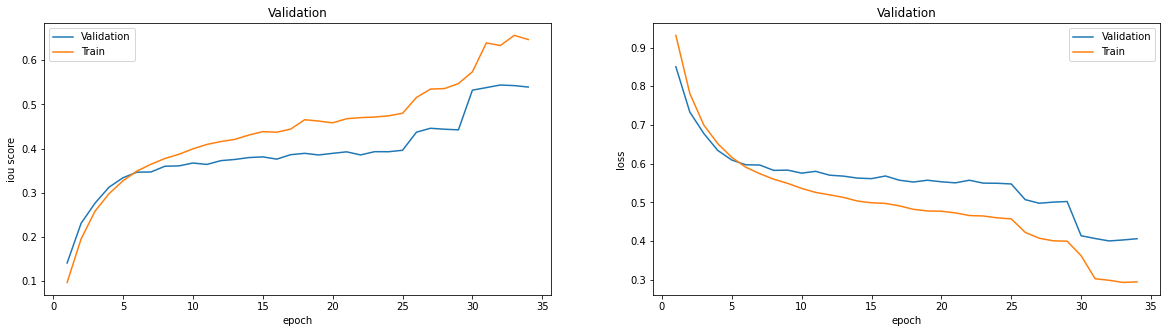

In [ ]:
plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(range(1, 35), history.history['val_iou_score'])
plt.plot(range(1, 35), history.history['iou_score'])
plt.title('Validation')
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.legend(['Validation', 'Train'], loc = 'upper left')

plt.subplot(122)
plt.plot(range(1, 35), history.history['val_loss'])
plt.plot(range(1, 35), history.history['loss'])
plt.title('Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.show()

- IOU has increased with the number of epochs and has achieved sort of saturation at the later epochs.

- Overall, Loss has decreased with the number of epochs.

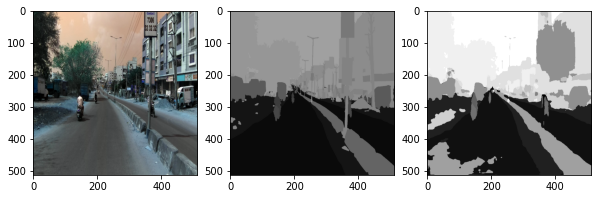

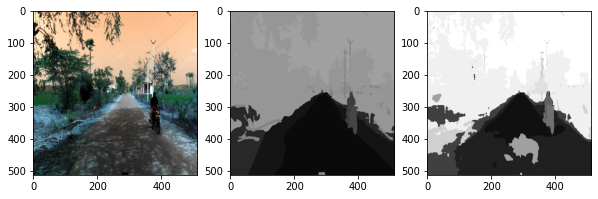

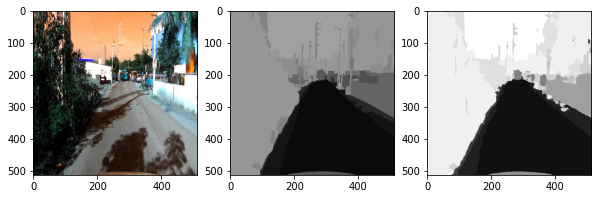

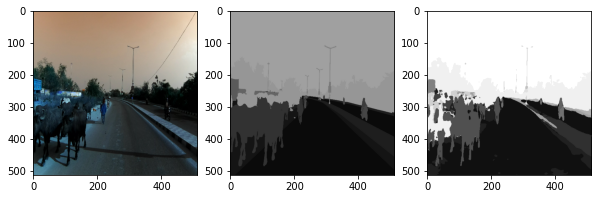

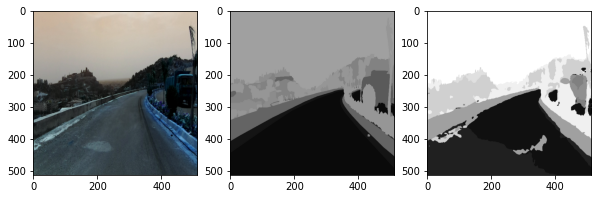

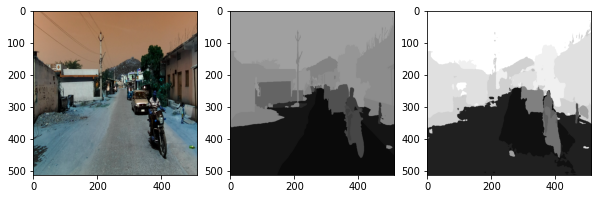

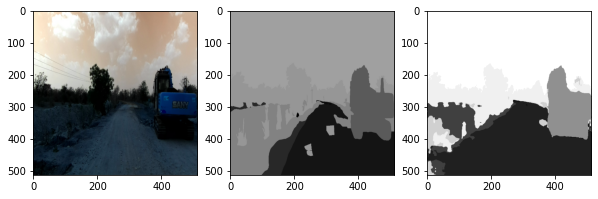

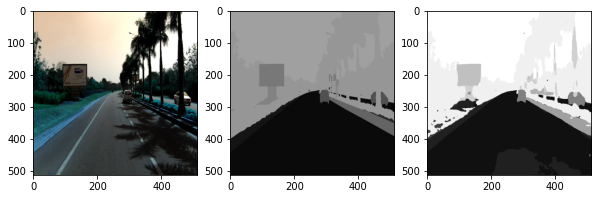

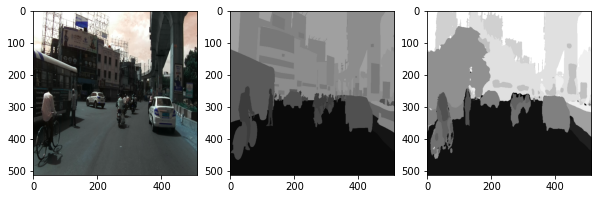

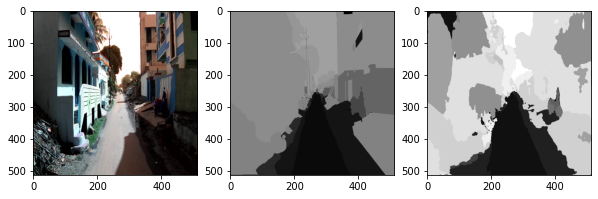

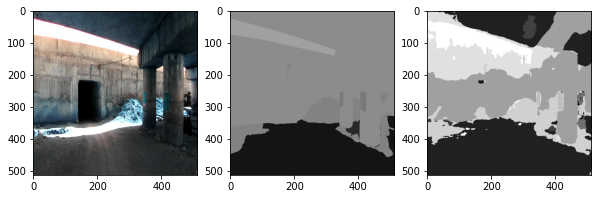

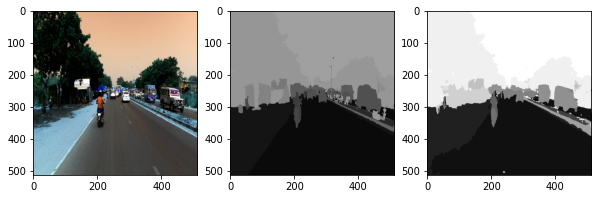

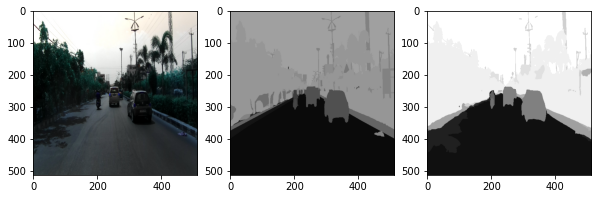

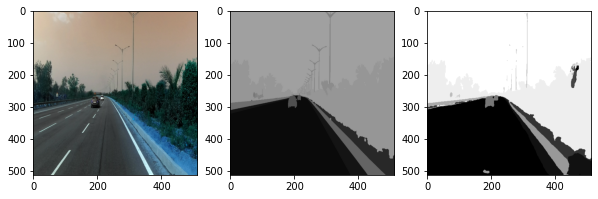

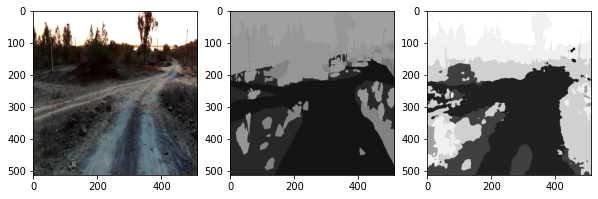

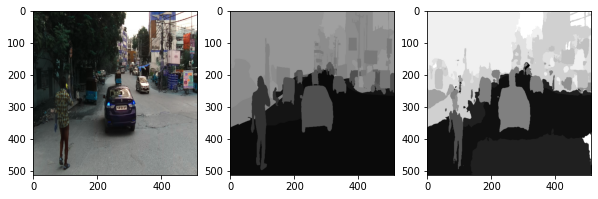

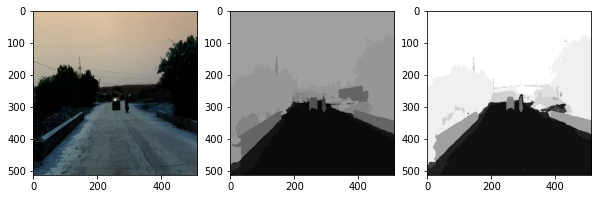

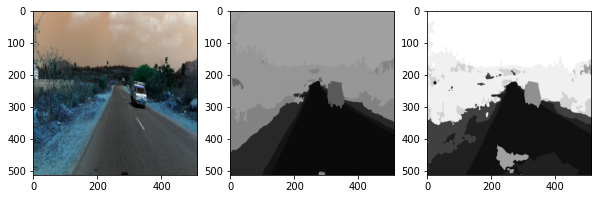

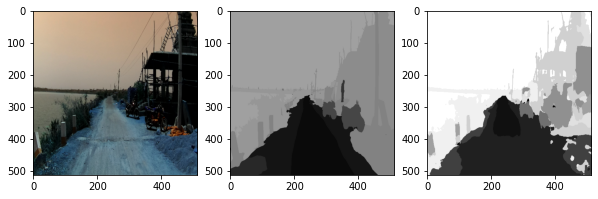

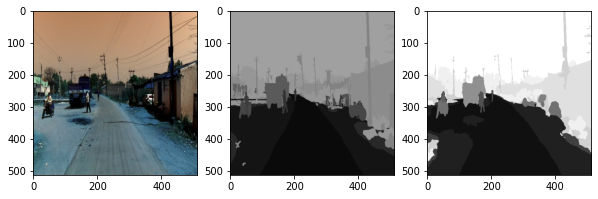

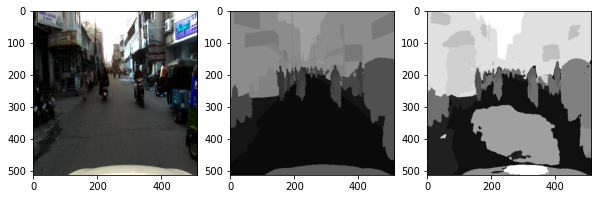

In [ ]:
for i in range(21):
  plt.figure(figsize = (10, 6))
  img_test = cv2.imread(X_test.values[i])
  img_test = cv2.resize(img_test, (512, 512))

  img_mask = cv2.imread(y_test.values[i])
  img_mask = cv2.resize(img_mask, (512, 512))

  predicted = unet_model.predict(img_test[np.newaxis,:,:,:])[0]
  plt.subplot(131)
  plt.imshow(img_test)
  plt.subplot(132)
  plt.imshow(img_mask, cmap = 'gray')
  plt.subplot(133)
  plt.imshow(tf.argmax(predicted, axis = -1), cmap = 'gray')
  plt.show()

# Training CANet

In [35]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [36]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name = 'conv_block'):
        super().__init__(name = name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.conv1 = Conv2D(filters = self.F1, kernel_size = 1, strides = (self.stride, self.stride), padding = 'same') #same
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        self.bn4 = BatchNormalization()
        self.act1 = Activation('relu')
        self.act2 = Activation('relu')
        self.act3 = Activation('relu')
        self.act4 = Activation('relu')
        self.conv2 = Conv2D(filters = self.F2, kernel_size = 3, padding = 'same') #same
        self.conv3 = Conv2D(filters = self.F3, kernel_size = 1)
        self.conv_parallel = Conv2D(self.F3, kernel_size = 3, strides = (self.stride, self.stride), padding = 'same') #same
        self.add = Add()

    def call(self, X):
        # write the architecutre that was mentioned above
        conv_1 = self.conv1(X)
        bn_1 = self.bn1(conv_1)
        act_1 = self.act1(bn_1)
        conv_2 = self.conv2(act_1)
        bn_2 = self.bn2(conv_2)
        act_2 = self.act3(bn_2)
        conv_3 = self.conv3(act_2)
        bn_3 = self.bn3(conv_3)

        conv_p = self.conv_parallel(X)
        bn_4 = self.bn4(conv_p)
        act_3 = self.act3(bn_4)

        ele_sum = self.add((act_3, bn_3))

        X = self.act4(ele_sum)
        return X

class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3, filters=[4,4,8], stride = 1, name = 'identity_block'):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv1 = Conv2D(filters = self.F1, kernel_size = 1, strides = (self.stride, self.stride), padding = 'same') #same
        self.conv2 = Conv2D(filters = self.F2, kernel_size = 3, strides = (self.stride, self.stride), padding = 'same') #same
        self.conv3 = Conv2D(filters = self.F3, kernel_size = 1, strides = (self.stride, self.stride), padding = 'same') #same
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        self.act1 = Activation('relu')
        self.act2 = Activation('relu')
        self.act3 = Activation('relu')
        self.add = Add()
        
    def call(self, X):
        # write the architecutre that was mentioned above
        conv_1 = self.conv1(X)
        bn_1 = self.bn1(conv_1)
        act_1 = self.act1(bn_1)
        conv_2 = self.conv2(act_1)
        bn_2 = self.bn2(conv_2)
        act_2 = self.act2(bn_2)
        conv_3 = self.conv3(act_2)
        bn_3 = self.bn3(conv_3)

        ele_sum = self.add((bn_3, X))
        X = self.act3(ele_sum)
        return X

class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.global_avg = GlobalAveragePooling2D()
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.conv = Conv2D(filters = 64, kernel_size = 1, activation = 'relu', padding = 'same') ## same, filters 64
        self.upsample = UpSampling2D(size = (32, 32), interpolation = 'bilinear')    # default size

        
    def call(self, X):
        # implement the global flow operation
        globalavg = self.global_avg(X)
        globalavg = globalavg[:,np.newaxis,np.newaxis,:]
        bn_1 = self.bn(globalavg)
        act_1 = self.act(bn_1)
        conv_1 = self.conv(act_1) ##32
        X = self.upsample(conv_1)
        return X

class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        #self.concat = concatenate()
        self.avgpool = AveragePooling2D()
        self.conv_1 = Conv2D(filters = 64, kernel_size = 3, strides = (1,1), padding = 'same')  #same
        self.conv_2 = Conv2D(filters = 64, kernel_size = 3, strides = (1,1), padding = 'same')  #same
        self.conv_3 = Conv2D(filters = 64, kernel_size = 1, strides = (1,1), padding = 'same')  #same
        self.conv_4 = Conv2D(filters = 64, kernel_size = 1, strides = (1,1), padding = 'same')  #same
        self.act_1 = Activation('relu')
        self.act_2 = Activation('sigmoid')
        self.bn = BatchNormalization()
        self.upsample = UpSampling2D(interpolation = 'bilinear')
        self.mul = Multiply()
        self.add = Add()

    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        #concat_1 = self.concat([INP, FLOW])
        concat_1 = concatenate([INP, FLOW])
        avgpool_1 = self.avgpool(concat_1)
        conv1 = self.conv_1(avgpool_1)
        conv2 = self.conv_2(conv1)

        conv3 = self.conv_3(conv2)
        act1 = self.act_1(conv3)
        conv4 = self.conv_4(act1)
        act2 = self.act_2(conv4)
        mul_1 = self.mul((act2, conv2))
        add_1 = self.add((mul_1, conv2))
        X = self.upsample(add_1)

        return X

class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters = 32, kernel_size = 3, strides = (1,1), activation = 'relu', padding = 'same') #same
        self.conv2 = Conv2D(filters = 32, kernel_size = 1, strides = (1,1), activation = 'relu', padding = 'same') #same
        self.act2 = Activation('sigmoid')
        self.bn = BatchNormalization()
        self.mul = Multiply()
        self.globalpool = GlobalMaxPool2D()
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        conv_1 = self.conv1(X)
        global_pool = self.globalpool(conv_1)
        global_pool = tf.expand_dims(global_pool, axis=1)
        global_pool = tf.expand_dims(global_pool, axis=2)
        conv_2 = self.conv2(global_pool)  
        bn_1 = self.bn(conv_2)
        act_2 = self.act2(bn_1)
        FSM_Conv_T = self.mul((act_2, conv_1))

        return FSM_Conv_T

class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters = 32, kernel_size = (7,1), padding = 'same', activation = 'relu', strides = 1) #same
        self.conv2 = Conv2D(filters = 32, kernel_size = (1,7), padding = 'same', activation = 'relu', strides = 1) #same
        self.conv3 = Conv2D(filters = 32, kernel_size = (1,7), padding = 'same', activation = 'relu', strides = 1) #same
        self.conv4 = Conv2D(filters = 32, kernel_size = (7,1), padding = 'same', activation = 'relu', strides = 1) #same
        self.conv5 = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', strides = 1) #same
        self.add1 = Add()
        self.add2 = Add()
    def call(self, X):
        # please implement the above mentioned architecture
        conv_1 = self.conv1(X)
        conv_2 = self.conv2(conv_1)
        conv_3 = self.conv3(X)
        conv_4 = self.conv4(conv_3)
        add_1 = self.add1((conv_2, conv_4))
        conv_5 = self.conv5(add_1)
        X = self.add2((conv_5, add_1)) 
        return X

# Model

In [37]:
inputs = Input(shape = (256, 256, 3))
c_0 = Conv2D(filters = 64, kernel_size = 2, strides=(1,1), activation='relu')(inputs)
b_0 = BatchNormalization()(c_0)
act_0 = Activation('relu')(b_0)
act_0 = MaxPool2D((2,2), strides=(2,2))(act_0)

c_1 = convolutional_block(filters = [4,4,8], stride = 2, name='conv_block_1')(act_0)
i_1 = identity_block(filters = [4,4,8], stride=1, name='identi_block_1')(c_1)

c_2 = convolutional_block(filters=[8,8,16], stride=2, name='conv_block_2')(i_1)
i_2 = identity_block(filters=[8,8,16], stride=1, name='identi_block_2_1')(c_2)
i_3 = identity_block(filters=[8,8,16], stride=1, name='identi_clock_2_2')(i_2)

c_3 = convolutional_block(filters=[16,16,32], stride=1, name='conv_block_3')(i_3)
i_4 = identity_block(filters=[16,16,32], stride=1, name='identi_block_3_1')(c_3)
i_5 = identity_block(filters=[16,16,32], stride=1, name='identi_block_3_2')(i_4)
i_6 = identity_block(filters=[16,16,32], stride=1, name='identi_block_3_3')(i_5)

c_4 = convolutional_block(filters=[32,32,64], stride=1, name='conv_block_4')(i_6)
i_7 = identity_block(filters=[32,32,64], stride=1, name='identi_block_4_1')(c_4)
i_8 = identity_block(filters=[32,32,64], stride=1, name='identi_block_4_2')(i_7)
i_9 = identity_block(filters=[32,32,64], stride=1, name='identi_block_4_3')(i_8)
i_10 = identity_block(filters=[32,32,64], stride=1, name='identi_block_4_4')(i_9)

gf_1 = global_flow()(i_10)

cf_1 = context_flow(name='cf_1')([gf_1, i_10])
cf_2 = context_flow(name='cf_2')([cf_1, i_10])
cf_3 = context_flow(name='cf_3')([cf_2, i_10])

sum_1 = Add()([gf_1, cf_1, cf_2, cf_3])

fsm_1 = fsm(name='fsm_1')(sum_1)

agcn_1 = agcn(name='agcn_1')(c_1)

up_1 = UpSampling2D(size=(2,2))(fsm_1)

concat_1 = concatenate([up_1, agcn_1])

conv_final = Conv2D(filters=21, kernel_size = 3, activation = 'relu', padding = 'same')(concat_1)

up_2 = UpSampling2D(size = (4,4))(conv_final)
out = Activation('softmax')(up_2)

canet_model = Model(inputs = inputs, outputs = out)

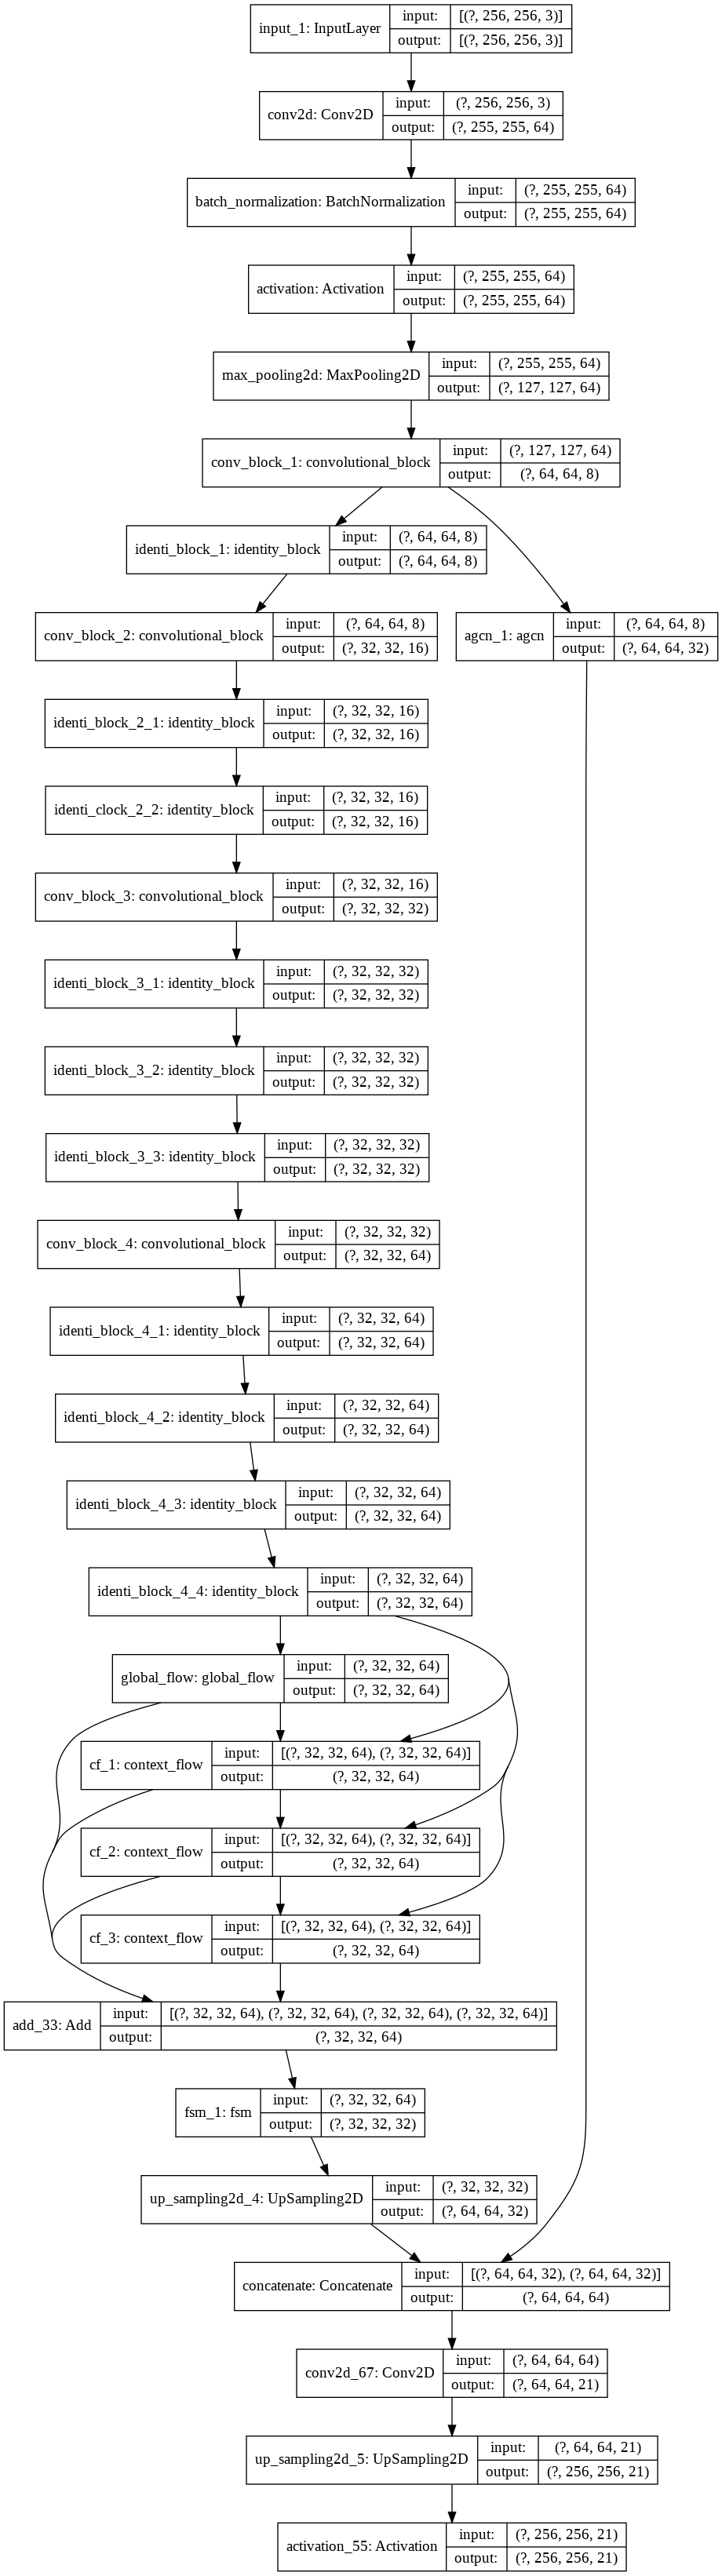

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(canet_model, show_shapes = True)

In [39]:
canet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 64) 832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [40]:
canet_model.compile(optim, focal_loss, metrics=[iou_score])
history_2 = canet_model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20, validation_data=test_dataloader)

Epoch 1/20
400/400 [==============================] - 267s 667ms/step - loss: 0.9705 - iou_score: 0.0773 - val_loss: 0.9216 - val_iou_score: 0.1040
Epoch 2/20
400/400 [==============================] - 264s 659ms/step - loss: 0.9078 - iou_score: 0.1145 - val_loss: 0.9006 - val_iou_score: 0.1210
Epoch 3/20
400/400 [==============================] - 270s 675ms/step - loss: 0.8834 - iou_score: 0.1308 - val_loss: 0.8717 - val_iou_score: 0.1387
Epoch 4/20
400/400 [==============================] - 267s 667ms/step - loss: 0.8727 - iou_score: 0.1386 - val_loss: 0.8620 - val_iou_score: 0.1423
Epoch 5/20
400/400 [==============================] - 270s 674ms/step - loss: 0.8573 - iou_score: 0.1485 - val_loss: 0.8553 - val_iou_score: 0.1509
Epoch 6/20
400/400 [==============================] - 270s 675ms/step - loss: 0.8475 - iou_score: 0.1551 - val_loss: 0.8383 - val_iou_score: 0.1590
Epoch 7/20
400/400 [==============================] - 262s 655ms/step - loss: 0.8389 - iou_score: 0.1609 - val_l

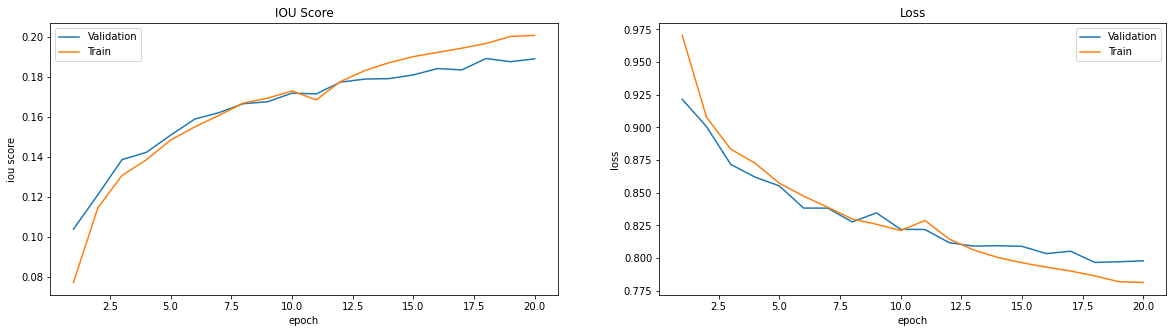

In [42]:
plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(range(1, 21), history_2.history['val_iou_score'])
plt.plot(range(1, 21), history_2.history['iou_score'])
plt.title('IOU Score')
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.legend(['Validation', 'Train'], loc = 'upper left')

plt.subplot(122)
plt.plot(range(1, 21), history_2.history['val_loss'])
plt.plot(range(1, 21), history_2.history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.show()

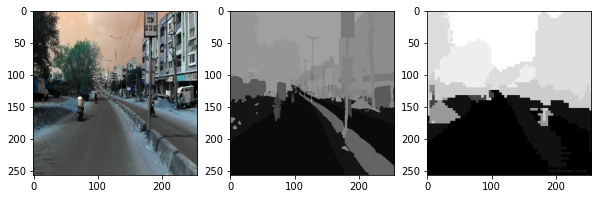

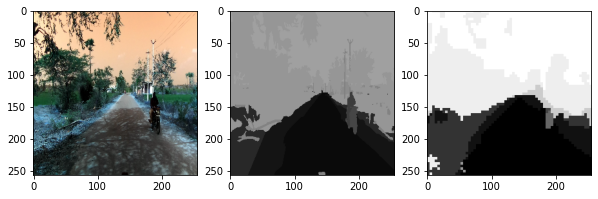

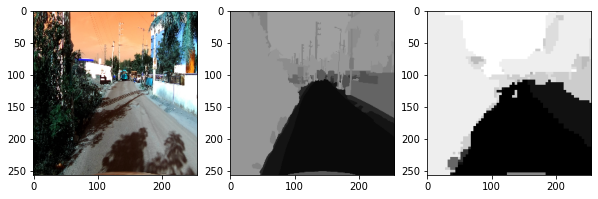

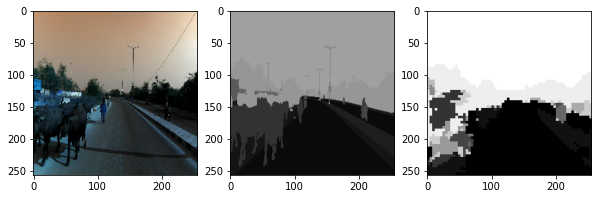

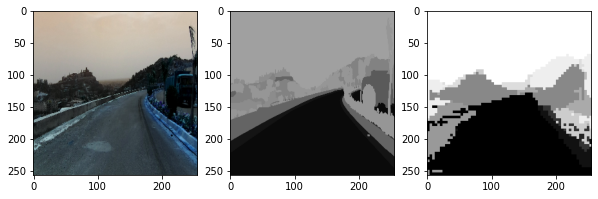

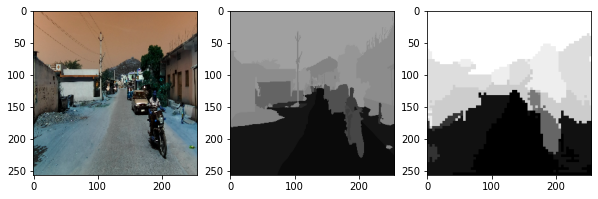

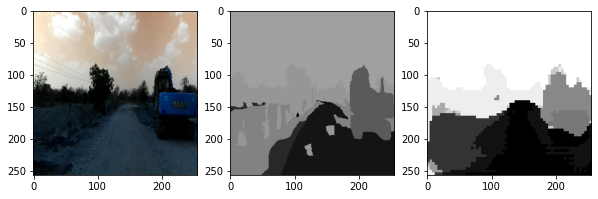

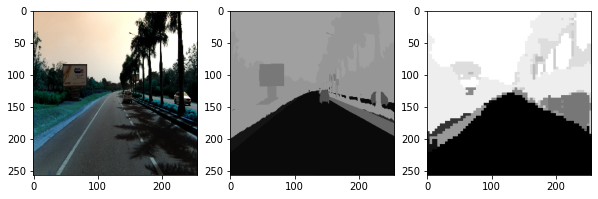

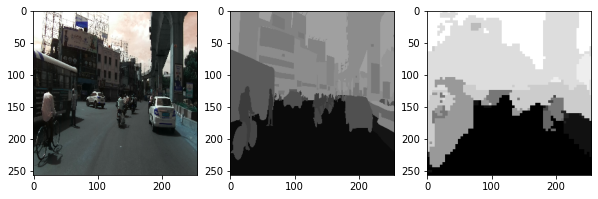

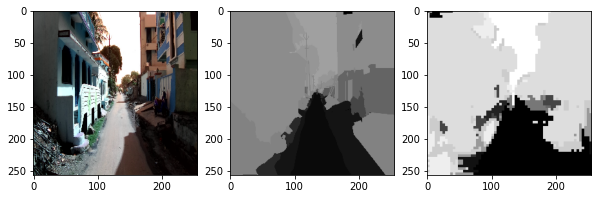

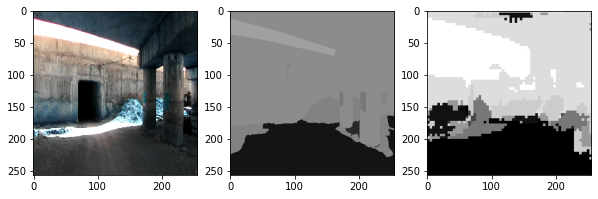

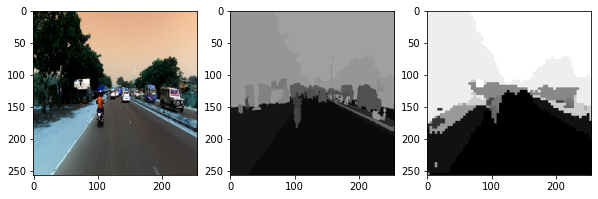

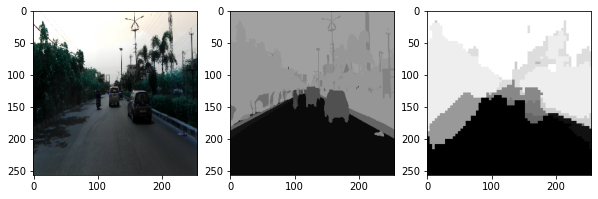

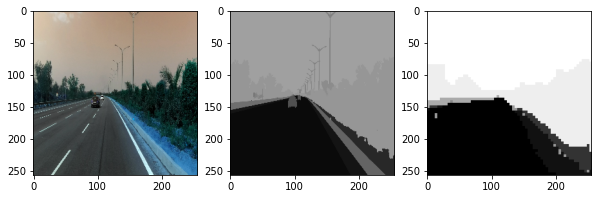

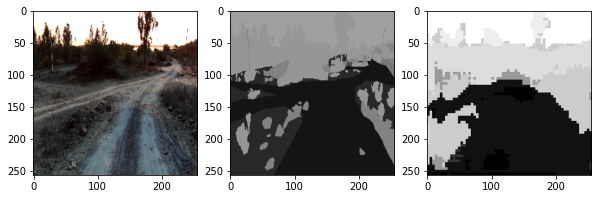

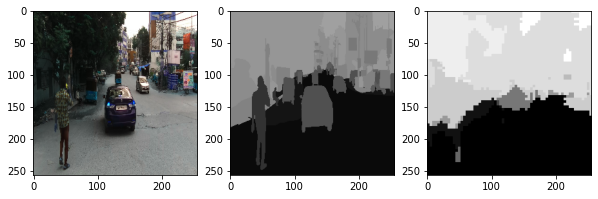

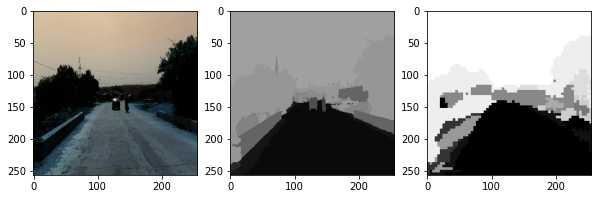

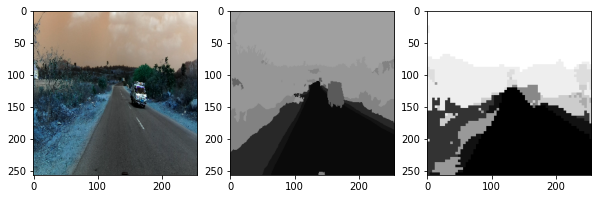

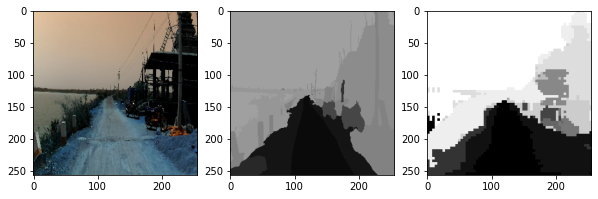

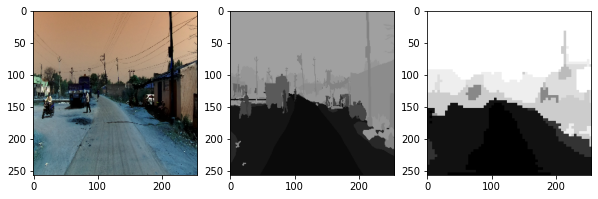

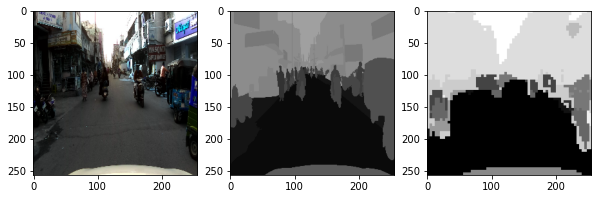

In [43]:
for i in range(21):
  plt.figure(figsize = (10, 6))
  img_test = cv2.imread(X_test.values[i])
  img_test = cv2.resize(img_test, (256, 256))

  img_mask = cv2.imread(y_test.values[i])
  img_mask = cv2.resize(img_mask, (256, 256))

  predicted = canet_model.predict(img_test[np.newaxis,:,:,:])[0]
  plt.subplot(131)
  plt.imshow(img_test)
  plt.subplot(132)
  plt.imshow(img_mask, cmap = 'gray')
  plt.subplot(133)
  plt.imshow(tf.argmax(predicted, axis = -1), cmap = 'gray')
  plt.show()

- Apart from the value of IOU score and loss obtained for both the models, which clearly suggests that UNET is better than CANet, one visible difference can be seen in terms of the clarity of the pixels obtained from both the models.

- Clarity obtained from UNET is much better than CANet.